## Download Dataset

In [ ]:
!nvidia-smi

Thu Dec  4 19:48:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:01:00.0 Off |                  N/A |
| 33%   47C    P8             33W /  575W |       0MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from IPython.display import clear_output

In [ ]:
%pip install matplotlib
%pip install gdown
clear_output()
print("Packages downloaded.")

Packages downloaded.


In [ ]:
!pip install gdown

Karena proses unduh langsung dari Google Drive sering terkena batas too many access, maka digunakan metode unduhan berbasis token autentikasi agar proses download tetap stabil dan berhasil

In [ ]:
%%bash

WORKDIR=$(pwd)
DATASET_DIR="$WORKDIR/dataset"
DATASET_ZIP="$WORKDIR/dataset.zip"

if [ -d "$DATASET_DIR" ]; then
    echo "📁 Folder dataset sudah ada. Skip download & unzip."

elif [ -f "$DATASET_ZIP" ]; then
    echo "🗂️ ZIP ditemukan tanpa folder. Sedang di-unzip..."
    unzip -q "$DATASET_ZIP" -d "$DATASET_DIR"
    rm "$DATASET_ZIP"
    echo "✅ Unzip selesai."

else
    echo "⬇️ Download dataset dari Google Drive..."
    curl -L \
      -H "Authorization: Bearer TOKEN_SAYA" \
      "https://www.googleapis.com/drive/v3/files/1kaKoOooBB-r-TVsSIl_HZV6whnx7OFr8?alt=media" \
      -o "$DATASET_ZIP"

    echo "🛠️ Unzip dataset..."
    unzip -q "$DATASET_ZIP" -d "$DATASET_DIR"
    rm "$DATASET_ZIP"
    echo "✅ Selesai download & unzip."
fi

📁 Folder dataset sudah ada. Skip download & unzip.


In [ ]:
import sys
print("Kernel Python:", sys.executable)

# upgrade pip/tooling
!{sys.executable} -m pip install --upgrade pip setuptools wheel

# common data / vision libs
!{sys.executable} -m pip install pandas numpy matplotlib tqdm pillow opencv-python scikit-image scikit-learn scipy timm torchmetrics transformers accelerate tokenizers evaluate

Kernel Python: /venv/main/bin/python


## Import Dependencies

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tqdm import tqdm
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_INP = "/workspace/dataset"
WORKDIR = "/workspace"
NUM_CLASSES = 11

print("DEVICE:", DEVICE)

DEVICE: cuda


## Dataset Loader

Pada task semantic segmentation, setiap image selalu dipasangkan dengan mask sebagai training target. Oleh karena itu, path image dan mask diambil serta di-sorted secara terpisah untuk data train, validation, dan test agar tetap saling berkorespondensi.

In [ ]:
import glob
def get_sorted_paths(folder_path):
    files = sorted(glob.glob(os.path.join(folder_path, "*")))
    return files

train_image_paths = get_sorted_paths(ROOT_INP+'/train/train-org-img')
train_mask_paths = get_sorted_paths(ROOT_INP+'/train/train-label-img')

val_image_paths = get_sorted_paths(ROOT_INP+'/val/val-org-img')
val_mask_paths = get_sorted_paths(ROOT_INP+'/val/val-label-img')

test_image_paths = get_sorted_paths(ROOT_INP+'/test/test-org-img')
test_mask_paths = get_sorted_paths(ROOT_INP+'/test/test-label-img')

Class RescueNetDataset digunakan untuk memuat image–mask pair pada proses training semantic segmentation. Image diproses dengan transform, sedangkan mask di-resize dan dikonversi menjadi tensor label sebagai training target.

In [ ]:
class RescueNetDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None, image_size=(512, 512)):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx]).convert('RGB')
        mask = Image.open(self.mask_path[idx]).convert('L')

        if self.transform:
            image = self.transform(image)

        mask = mask.resize(self.image_size, Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)
        # mask = np.clip(mask, 0, 9)
        mask = torch.from_numpy(mask).long()

        return image, mask

## Dataset Prep

Pada tahap ini digunakan transform Resize (512×512) dan ToTensor untuk menyeragamkan ukuran input model. Dataset kemudian dimuat ke dalam DataLoader dengan batch size = 8 untuk proses training, validation, dan testing.

In [ ]:
train_test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

train_dataset = RescueNetDataset(train_image_paths, train_mask_paths, transform=train_test_transform)
val_dataset = RescueNetDataset(val_image_paths, val_mask_paths, transform=train_test_transform)
test_dataset = RescueNetDataset(test_image_paths, test_mask_paths, transform=train_test_transform)

BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

## Modelling

CSDNet menggunakan EfficientNet-B5 (pretrained) sebagai backbone untuk mengekstraksi fitur multi-level (f1–f4).

- Branch 1 (Targeted Enhancement) memanfaatkan fitur awal f1 yang diperkaya dengan ASPP dan dipandu oleh sinyal dari modul deteksi untuk menonjolkan area penting.

- Branch 2 (Deep Contextual Attention) memproses fitur terdalam f4 menggunakan Depthwise Separable Convolution, Transformer Encoder, dan ASPP untuk menangkap konteks global.

- Branch 3 (Multi-Scale Fusion) menggabungkan fitur menengah f2 dan f3 melalui konvolusi 1×1, upsampling, dan konvolusi 3×3.

Ketiga branch kemudian di-upsample ke ukuran yang sama, dikonkatenasi, dan diproses oleh classifier untuk menghasilkan output semantic segmentation 11 kelas pada resolusi penuh.

In [ ]:
import timm

class DWSC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride,
                                   padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=256):
        super().__init__()
        dilations = [1, 6, 12, 18]
        self.aspp_blocks = nn.ModuleList()

        self.aspp_blocks.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))

        for dilation in dilations[1:]:
            self.aspp_blocks.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))

        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.project = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        for block in self.aspp_blocks:
            res.append(block(x))

        g = self.global_pool(x)
        g = F.interpolate(g, size=x.shape[2:], mode='bilinear', align_corners=False)
        res.append(g)

        res = torch.cat(res, dim=1)
        return self.project(res)

class TargetedEnhancementModule(nn.Module):
    def __init__(self, f1_channels, detector_channels=256, fusion_dim=256):
        super().__init__()
        self.aspp_f1 = ASPP(f1_channels, fusion_dim)

        self.phi = nn.Sequential(
            nn.Conv2d(detector_channels, fusion_dim, 1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, f1, f_det):

        f1_processed = self.aspp_f1(f1)

        f_det_processed = self.phi(f_det)
        f_det_resized = F.interpolate(f_det_processed, size=f1_processed.shape[2:],
                                      mode='bilinear', align_corners=False)

        return f1_processed * f_det_resized

class DeepContextualAttention(nn.Module):
    def __init__(self, in_channels, dim=256):
        super().__init__()
        self.dwsc_in = DWSC(in_channels, dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=4, dim_feedforward=dim*2, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.aspp = ASPP(dim, dim)

    def forward(self, x):
        B, C, H, W = x.shape

        x = self.dwsc_in(x) # (B, dim, H, W)

        tokens = x.flatten(2).transpose(1, 2)

        tokens = self.transformer(tokens)

        x_trans = tokens.transpose(1, 2).view(B, -1, H, W)

        x_out = self.aspp(x_trans)

        return x_out

class MultiScaleFusion(nn.Module):
    def __init__(self, f2_channels, f3_channels, out_dim=256):
        super().__init__()
        self.psi2 = nn.Conv2d(f2_channels, out_dim, 1)
        self.psi3 = nn.Conv2d(f3_channels, out_dim, 1)

        self.fusion_conv = nn.Sequential(
            nn.Conv2d(out_dim * 2, out_dim, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, f2, f3):
        f2_hat = self.psi2(f2)
        f3_hat = self.psi3(f3)

        f3_hat_up = F.interpolate(f3_hat, size=f2_hat.shape[2:], mode='bilinear', align_corners=False)

        f_gen = torch.cat([f2_hat, f3_hat_up], dim=1)
        return self.fusion_conv(f_gen)

class CSDNet(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()

        self.encoder = timm.create_model(
            "efficientnet_b5",
            pretrained=True,
            features_only=True,
            out_indices=(0, 1, 2, 3)
        )

        dims = self.encoder.feature_info.channels()
        f1_c, f2_c, f3_c, f4_c = dims[0], dims[1], dims[2], dims[3]

        fusion_dim = 128

        self.mod1_detection = TargetedEnhancementModule(f1_c, detector_channels=256, fusion_dim=fusion_dim)

        self.mod2_transformer = DeepContextualAttention(f4_c, dim=fusion_dim)

        self.mod3_cnn = MultiScaleFusion(f2_c, f3_c, out_dim=fusion_dim)

        self.classifier = nn.Sequential(
            nn.Conv2d(fusion_dim * 3, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(256, num_classes, 1)
        )

        self.detector_dummy_layer = nn.Conv2d(3, 256, kernel_size=32, stride=32)

    def get_detection_features(self, x):
        with torch.no_grad():
            det_feats = self.detector_dummy_layer(x)
        return det_feats

    def forward(self, x):
        input_shape = x.shape[2:]

        feats = self.encoder(x)
        f1, f2, f3, f4 = feats[0], feats[1], feats[2], feats[3]

        f_det_raw = self.get_detection_features(x)

        feat_branch1 = self.mod1_detection(f1, f_det_raw)

        feat_branch2 = self.mod2_transformer(f4)

        feat_branch3 = self.mod3_cnn(f2, f3)

        target_size = feat_branch1.shape[2:]

        feat_branch2_up = F.interpolate(feat_branch2, size=target_size, mode='bilinear', align_corners=False)
        feat_branch3_up = F.interpolate(feat_branch3, size=target_size, mode='bilinear', align_corners=False)

        f_final = torch.cat([feat_branch1, feat_branch2_up, feat_branch3_up], dim=1)

        logits = self.classifier(f_final)

        logits = F.interpolate(logits, size=input_shape, mode='bilinear', align_corners=False)

        return logits

model = CSDNet(num_classes=11)

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


## Train n Eval

In [ ]:
print(f"Train Images: {len(train_image_paths)}, Train Masks: {len(train_mask_paths)}")
print(f"Val Images: {len(val_image_paths)}, Val Masks: {len(val_mask_paths)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE USED : {device}")

Train Images: 3595, Train Masks: 3595
Val Images: 449, Val Masks: 449
DEVICE USED : cuda


- Model CSDNet diinisialisasi dengan 11 kelas output.

- Digunakan Focal Loss untuk mengatasi ketidakseimbangan kelas, dengan konsep: loss cross-entropy * faktor (1 − pt) ^ gamma, sehingga sampel yang sulit diprediksi diberi bobot lebih besar.
- Digunakan Jaccard Loss (IoU Loss) dengan konsep: 1 - (irisan prediksi ∩ label) / (gabungan prediksi ∪ label), sehingga kualitas overlap segmentasi dimaksimalkan.

- Kedua loss tersebut kemudian dikombinasikan dengan cara dijumlahkan langsung menjadi satu fungsi total loss agar pembelajaran lebih stabil dan akurat.
- Proses optimasi menggunakan SGD dengan momentum, sedangkan learning rate diturunkan otomatis oleh ReduceLROnPlateau ketika nilai validasi stagnan.

In [ ]:
model = CSDNet(num_classes=11).to(device)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, ignore_index=255):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none', weight=alpha, ignore_index=ignore_index)

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


class JaccardLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        preds = torch.softmax(logits, dim=1)

        target_1hot = torch.nn.functional.one_hot(targets, num_classes).permute(0,3,1,2)

        intersection = (preds * target_1hot).sum(dim=(2,3))
        union = preds.sum(dim=(2,3)) + target_1hot.sum(dim=(2,3)) - intersection

        iou = (intersection + self.eps) / (union + self.eps)
        return 1 - iou.mean()


focal_loss = FocalLoss(gamma=2.0)
jaccard_loss = JaccardLoss()


def total_loss_fn(pred, target):
    return focal_loss(pred, target) + jaccard_loss(pred, target)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=10,
    factor=0.1,
    min_lr=1e-4
)

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


- Bagian ini mengatur training loop utama untuk CSDNet selama 25 epoch, dengan perhitungan train loss, val loss, dan validation mIoU di setiap epoch.

- Untuk evaluasi performa, digunakan JaccardIndex (IoU) per kelas (average=None), lalu di-average untuk mendapatkan mIoU sebagai metrik utama kualitas segmentasi.

- Selama training, model dijalankan dalam mode train(), dihitung total_loss_fn(preds, masks), lalu dilakukan backpropagation + optimizer.step(); sedangkan pada fase validasi model di-freeze (eval() + no_grad()) dan prediksi diubah menjadi label dengan argmax sebelum di-update ke metrik IoU.

- Setelah tiap epoch, scheduler.step(val_loss) dipanggil untuk menyesuaikan learning rate berdasarkan val loss, dan jika mIoU_val lebih tinggi dari best_mIoU, bobot model disimpan sebagai best_model_csdnet.pth.

In [ ]:
from torchmetrics import JaccardIndex
from tqdm.auto import tqdm

EPOCHS = 25

metric_val   = JaccardIndex(task="multiclass", num_classes=11, average=None).to(device)

best_mIoU = 0.0

history = {
    "train_loss": [],
    "val_loss": [],
    "val_miou": []
}

for epoch in range(EPOCHS):

    model.train()
    train_loss = 0

    if hasattr(model, 'detector_dummy_layer'):
        model.detector_dummy_layer.eval()

    for images, masks in tqdm(train_loader, desc=f"Train {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = total_loss_fn(preds, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"🎯 Train Loss: {train_loss:.4f}")
    history["train_loss"].append(train_loss)

    model.eval()
    val_loss = 0
    metric_val.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Val {epoch+1}/{EPOCHS}"):
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            loss = total_loss_fn(preds, masks)
            val_loss += loss.item()

            pred_mask = preds.argmax(dim=1)
            metric_val.update(pred_mask, masks)

    val_loss /= len(val_loader)
    iou_val_per_class = metric_val.compute()
    mIoU_val = iou_val_per_class.mean().item()

    history["val_loss"].append(val_loss)
    history["val_miou"].append(mIoU_val)

    print(f"""
============================== Epoch: {epoch+1}/{EPOCHS}
Train Loss: {train_loss:.4f}
Val Loss:   {val_loss:.4f}   | Val mIoU: {mIoU_val:.4f}
==============================
""")


    scheduler.step(val_loss)

    if best_mIoU < mIoU_val:
        best_mIoU = mIoU_val
        torch.save(model.state_dict(), "best_model_csdnet.pth")
        print("Model disimpan (best so far).")

print("Training Selesai!")

Train 1/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 1.3463


Val 1/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 1/25
Train Loss: 1.3463
Val Loss:   1.1644   | Val mIoU: 0.3671



Model disimpan (best so far).


Train 2/25:   0%|          | 0/449 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

🎯 Train Loss: 1.1347


Val 2/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 2/25
Train Loss: 1.1347
Val Loss:   1.0593   | Val mIoU: 0.4520



Model disimpan (best so far).


Train 3/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 1.0738


Val 3/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 3/25
Train Loss: 1.0738
Val Loss:   1.0295   | Val mIoU: 0.4642

Model disimpan (best so far).


Train 4/25:   0%|          | 0/449 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

if w.is_alive():

^

Exception ignored in: 

^

^

^

^

^

Exception ignored in: 

^

^

^

^

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

^

^

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

^

^

Traceback (most recent call last):


^

^

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


^

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


^

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

^

AssertionError

self._shutdown_workers()

^

: 

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

can only test a child process

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


^

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

^

^

^

assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

: 

^

^

can only test a child process

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

: 

^

^

can only test a child process

^

^

^

^

^

AssertionError

: 

can only test a child process

🎯 Train Loss: 1.0262


Val 4/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 4/25
Train Loss: 1.0262
Val Loss:   1.0237   | Val mIoU: 0.5021

Model disimpan (best so far).


Train 5/25:   0%|          | 0/449 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


Exception ignored in: 

self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


if w.is_alive():

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

: 

can only test a child process

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


Exception ignored in: 

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


Traceback (most recent call last):


if w.is_alive():

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

^

assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

^

: 

^

can only test a child process

^

^

^

AssertionError

: 

can only test a child process

🎯 Train Loss: 0.9932


Val 5/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 5/25
Train Loss: 0.9932
Val Loss:   0.9841   | Val mIoU: 0.5371



Model disimpan (best so far).


Train 6/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.9719


Val 6/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 6/25
Train Loss: 0.9719
Val Loss:   0.9688   | Val mIoU: 0.5631



Model disimpan (best so far).


Train 7/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.9530


Val 7/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 7/25
Train Loss: 0.9530
Val Loss:   0.9635   | Val mIoU: 0.5645

Model disimpan (best so far).


Train 8/25:   0%|          | 0/449 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


Traceback (most recent call last):


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

Exception ignored in: 

^

^

Exception ignored in: 

^

^

^

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

^

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


^

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


^

^

Traceback (most recent call last):


^

self._shutdown_workers()

^

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


^

^

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

if w.is_alive():

self._shutdown_workers()

^

assert self._parent_pid == os.getpid(), 'can only test a child process'

^

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


^

^

^

if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

^

^

^

^

^

assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

^

^

^

assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

^

^

^

^

^

^

^

assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

^

: 

^

^

can only test a child process

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

^

: 

can only test a child process

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

: 

^

can only test a child process

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

🎯 Train Loss: 0.9567


Val 8/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 8/25
Train Loss: 0.9567
Val Loss:   0.9659   | Val mIoU: 0.5789



Model disimpan (best so far).


Train 9/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.9173


Val 9/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 9/25
Train Loss: 0.9173
Val Loss:   0.9711   | Val mIoU: 0.5785



Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Exception ignored in: 

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


if w.is_alive():

self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

^

^

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

: 

^

can only test a child process

AssertionError

: 

can only test a child process

Train 10/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8977


Val 10/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 10/25
Train Loss: 0.8977
Val Loss:   0.9774   | Val mIoU: 0.5725



Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


Exception ignored in: 

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


if w.is_alive():

self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

^

assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

: 

^

can only test a child process

^

^

^

^

^

AssertionError

: 

can only test a child process

Train 11/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8766


Val 11/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 11/25
Train Loss: 0.8766
Val Loss:   0.9555   | Val mIoU: 0.6119



Model disimpan (best so far).


Train 12/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8683


Val 12/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 12/25
Train Loss: 0.8683
Val Loss:   0.9468   | Val mIoU: 0.6376



Model disimpan (best so far).


Train 13/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8499


Val 13/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 13/25
Train Loss: 0.8499
Val Loss:   0.9725   | Val mIoU: 0.6244



Train 14/25:   0%|          | 0/449 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


Exception ignored in: 

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

self._shutdown_workers()

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

^

: 

^

can only test a child process

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

🎯 Train Loss: 0.8493


Val 14/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 14/25
Train Loss: 0.8493
Val Loss:   0.9737   | Val mIoU: 0.6015



Train 15/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8320


Val 15/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 15/25
Train Loss: 0.8320
Val Loss:   0.9645   | Val mIoU: 0.6216



Train 16/25:   0%|          | 0/449 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

Exception ignored in: 

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


^

^

assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

AssertionError

^

: 

^

can only test a child process

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

🎯 Train Loss: 0.8177


Val 16/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 16/25
Train Loss: 0.8177
Val Loss:   0.9644   | Val mIoU: 0.6337



Train 17/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8096


Val 17/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 17/25
Train Loss: 0.8096
Val Loss:   0.9651   | Val mIoU: 0.6425



Model disimpan (best so far).


Train 18/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8025


Val 18/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 18/25
Train Loss: 0.8025
Val Loss:   0.9726   | Val mIoU: 0.6343



Train 19/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8042


Val 19/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 19/25
Train Loss: 0.8042
Val Loss:   0.9801   | Val mIoU: 0.6306



Train 20/25:   0%|          | 0/449 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

🎯 Train Loss: 0.7864


Val 20/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 20/25
Train Loss: 0.7864
Val Loss:   0.9768   | Val mIoU: 0.6263



Train 21/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.7813


Val 21/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 21/25
Train Loss: 0.7813
Val Loss:   0.9876   | Val mIoU: 0.6507



Model disimpan (best so far).


Train 22/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.7669


Val 22/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 22/25
Train Loss: 0.7669
Val Loss:   0.9884   | Val mIoU: 0.6586



Model disimpan (best so far).


Train 23/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.7613


Val 23/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 23/25
Train Loss: 0.7613
Val Loss:   0.9890   | Val mIoU: 0.6604

Model disimpan (best so far).


Train 24/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.7415


Val 24/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 24/25
Train Loss: 0.7415
Val Loss:   0.9692   | Val mIoU: 0.6776



Model disimpan (best so far).


Train 25/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.7322


Val 25/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 25/25
Train Loss: 0.7322
Val Loss:   0.9791   | Val mIoU: 0.6810



Model disimpan (best so far).
Training Selesai!


Plot  loss

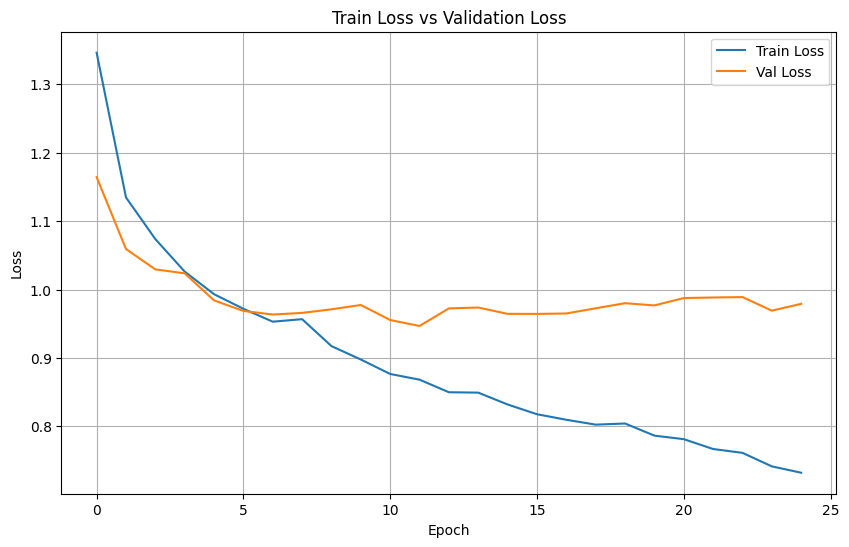

In [ ]:
import matplotlib.pyplot as plt

# Plot Train Loss vs Val Loss
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import json

output_path = WORKDIR+"/history_csdnet.json"

with open(output_path, "w") as f:
    json.dump(history, f, indent=4)

print("File saved to:", output_path)

File saved to: /workspace/history_csdnet.json


## Testing

In [ ]:
import torch
from tqdm.auto import tqdm
from torchmetrics import JaccardIndex

def test_model(model, test_loader, device):
    metric = JaccardIndex(
        task="multiclass",
        num_classes=NUM_CLASSES,
        ignore_index=255,
        average="none"
    ).to(device)

    model.to(device)

    model.eval()
    test_loss = 0.0
    print("Mulai Testing (menggunakan JaccardIndex)...")

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):

            images, masks = images.to(device), masks.to(device)

            preds = model(images)

            loss = total_loss_fn(preds, masks)
            test_loss += loss.item()

            pred_mask = torch.argmax(preds, dim=1)
            metric.update(pred_mask, masks)

    iou_per_class = metric.compute()

    mIoU = iou_per_class.mean().item()

    print("\n=== HASIL TESTING ===")
    print(f"Mean IoU (mIoU): {mIoU:.4f}")
    print("-" * 30)

    class_names = [
        "Background", "Water", "Building No Damage", "Building Minor Damage",
        "Building Major Damage", "Building Total Destruction", "Road-Clear",
        "Road-Blocked", "Vehicle", "Tree", "Pool"
    ]

    for i, iou in enumerate(iou_per_class):
        name = class_names[i] if i < len(class_names) else f"Class {i}"
        print(f"{name:25s}: {iou.item():.4f}")

    metric.reset()
    return mIoU, iou_per_class

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F

NUM_CLASSES = 11
model = CSDNet(num_classes=NUM_CLASSES).to(device)

ckpt_path = WORKDIR + "/best_model_csdnet.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

if isinstance(ckpt, dict):
    if "model_state_dict" in ckpt:
        ckpt_state = ckpt["model_state_dict"]
    elif "state_dict" in ckpt:
        ckpt_state = ckpt["state_dict"]
    elif "model" in ckpt:
        ckpt_state = ckpt["model"]
    else:
        ckpt_state = ckpt
else:
    ckpt_state = ckpt

try:
    model.load_state_dict(ckpt_state)
    print("Checkpoint loaded with strict=True (perfect match).")
except Exception as e:
    print("Strict load failed:", e)
    model_state = model.state_dict()
    compatible = {}
    mismatched = []
    for k, v in ckpt_state.items():
        if k in model_state:
            if v.shape == model_state[k].shape:
                compatible[k] = v
            else:
                mismatched.append((k, v.shape, model_state[k].shape))
    print(f"Compatible keys: {len(compatible)} / {len(model_state)}")
    if mismatched:
        print("Mismatched params (name, ckpt_shape, model_shape) - top 10 shown:")
        for item in mismatched[:10]:
            print(" ", item)
    model_state.update(compatible)
    model.load_state_dict(model_state)
    print("Loaded compatible weights; mismatched layers left as randomly initialized.")

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Checkpoint loaded with strict=True (perfect match).


In [ ]:
class_names = [
        "Background", "Water", "Building No Damage", "Building Minor Damage",
        "Building Major Damage", "Building Total Destruction", "Road-Clear",
        "Road-Blocked", "Vehicle", "Tree", "Pool"
    ]

test_mIoU, test_iou_per_class = test_model(model, test_loader, device)

print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n\n\n")
print(f"===================== IoU Per Class ========================")
for i, iou in enumerate(test_iou_per_class):
        name = class_names[i] if i < len(class_names) else f"Class {i}"
        print(f"{name:25s}: {iou.item():.4f}")


Mulai Testing (menggunakan JaccardIndex)...


Testing:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a74266520>

Traceback (most recent call last):


  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


self._shutdown_workers()

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


if w.is_alive():

^

^

^

^

^

^

^

^

^

^

^

^

  File "/venv/main/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

^

AssertionError

: 

can only test a child process


=== HASIL TESTING ===
Mean IoU (mIoU): 0.6697
------------------------------
Background               : 0.8403
Water                    : 0.8280
Building No Damage       : 0.6779
Building Minor Damage    : 0.5810
Building Major Damage    : 0.5630
Building Total Destruction: 0.5980
Road-Clear               : 0.6100
Road-Blocked             : 0.7602
Vehicle                  : 0.4460
Tree                     : 0.8258
Pool                     : 0.6370
===================== Hasil Testing mIoU 0.6697450280189514 ========================

===================== Hasil Testing mIoU 0.6697450280189514 ========================

===================== Hasil Testing mIoU 0.6697450280189514 ========================

===================== Hasil Testing mIoU 0.6697450280189514 ========================

===================== Hasil Testing mIoU 0.6697450280189514 ========================



===================== IoU Per Class ========================
Background               : 0.8403
Water               

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# import os
# from matplotlib.patches import Patch

# CLASS_NAMES = [
#     "Background",
#     "Water",
#     "Building No Damage",
#     "Building Minor Damage",
#     "Building Major Damage",
#     "Building Total Destruction",
#     "Road-Clear",
#     "Road-Blocked",
#     "Vehicle",
#     "Tree",
#     "Pool"
# ]

# LABEL_COLORS = np.array([
#     [0, 0, 0],         # Background
#     [30, 230, 255],    # Water
#     [184, 115, 117],   # Building No Damage
#     [216, 255, 0],     # Building Minor Damage
#     [252, 199, 0],     # Building Major Damage
#     [255, 0, 0],       # Building Total Destruction
#     [140, 140, 140],   # Road-Clear
#     [151, 0, 255],     # Road-Blocked
#     [255, 0, 246],     # Vehicle
#     [0, 255, 0],       # Tree
#     [244, 255, 0]      # Pool
# ])
# def decode_segmap(mask):
#     r = np.zeros_like(mask).astype(np.uint8)
#     g = np.zeros_like(mask).astype(np.uint8)
#     b = np.zeros_like(mask).astype(np.uint8)

#     for l in range(0, len(LABEL_COLORS)):
#         idx = mask == l
#         r[idx] = LABEL_COLORS[l, 0]
#         g[idx] = LABEL_COLORS[l, 1]
#         b[idx] = LABEL_COLORS[l, 2]

#     rgb = np.stack([r, g, b], axis=2)
#     return rgb

# def find_indices_by_filename(dataset, target_ids):
#     found_indices = []
#     for target in target_ids:
#         found = False
#         for idx, path in enumerate(dataset.image_path):
#             if str(target) in os.path.basename(path):
#                 found_indices.append(idx)
#                 found = True
#                 break
#         if not found:
#             return
#     return found_indices

# def visualize_specific_images(model, dataset, target_ids, device, processor):
#     model.eval()

#     indices = find_indices_by_filename(dataset, target_ids)

#     num_samples = len(indices)
#     fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6 * num_samples))

#     if num_samples == 1:
#         axes = axes.reshape(1, -1)

#     for row_idx, idx in enumerate(indices):
#         image, mask = dataset[idx]

#         filename = os.path.basename(dataset.image_path[idx])

#         inputs = processor(
#             images=[image],
#             return_tensors="pt",
#             do_resize=False,
#             do_rescale=False
#         )
#         inputs = {k: v.to(device) for k, v in inputs.items()}

#         with torch.no_grad():
#             outputs = model(**inputs)

#         target_sizes = [(mask.shape[0], mask.shape[1])]
#         pred_map = processor.post_process_semantic_segmentation(
#             outputs, target_sizes=target_sizes
#         )[0]

#         img_np = image.permute(1, 2, 0).numpy()

#         mask_rgb = decode_segmap(mask.numpy())
#         pred_rgb = decode_segmap(pred_map.cpu().numpy())

#         axes[row_idx, 0].imshow(img_np)
#         axes[row_idx, 0].set_title(f"ID: {filename}\nOriginal Image")
#         axes[row_idx, 0].axis("off")

#         axes[row_idx, 1].imshow(mask_rgb)
#         axes[row_idx, 1].set_title("Ground Truth")
#         axes[row_idx, 1].axis("off")

#         axes[row_idx, 2].imshow(pred_rgb)
#         axes[row_idx, 2].set_title("Mask2Former Prediction")
#         axes[row_idx, 2].axis("off")

#     handles = [Patch(color=LABEL_COLORS[i]/255.0, label=CLASS_NAMES[i]) for i in range(len(CLASS_NAMES))]
#     fig.legend(handles=handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.0), fontsize=12)

#     plt.savefig('visualisasi_prediksi_rescuenet.png', bbox_inches='tight', dpi=300)

#     plt.tight_layout()
#     plt.subplots_adjust(bottom=0.08)
#     plt.show()

# target_ids = ["10794", "10801", "10807"]

# visualize_specific_images(model, test_dataset, target_ids, device, processor)

In [ ]:
# model.eval()
# import matplotlib.pyplot as plt

# test_imgs, test_masks = next(iter(test_loader))

# with torch.no_grad():
#     inputs = [{"image": test_imgs[0].to(cfg.MODEL.DEVICE), "height": 512, "width": 512}]

#     outputs = model(inputs)

#     pred_mask = outputs[0]["sem_seg"].argmax(dim=0).cpu().numpy()

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1); plt.title("Prediction"); plt.imshow(pred_mask)
# plt.subplot(1, 2, 2); plt.title("Ground Truth"); plt.imshow(test_masks[0])
# plt.show()